1. Loading dependencies.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import sys
from windrose import WindroseAxes

2. Summary Statistics & Missing-Value Report

In [21]:
df = pd.read_csv('..\\data\\sierraleone-bumbuna.csv', parse_dates=['Timestamp'])  # add parse_dates parameter
# 1. Summary statistics for all numeric columns
numeric_summary = df.describe()

# 2. Count of missing values in each column
missing_counts = df.isna().sum()

# 3. Identifying columns with >5% missing values
threshold = 0.05 * len(df)
high_na_columns = missing_counts[missing_counts > threshold].index.tolist()

# Printing the results
print("Summary Statistics (Numeric Columns):\n", numeric_summary)
print("\nMissing Value Counts:\n", missing_counts)
print("\nColumns with >5% Missing Values:\n", high_na_columns)

Summary Statistics (Numeric Columns):
                            Timestamp            GHI            DNI  \
count                         525600  525600.000000  525600.000000   
mean   2022-04-30 12:00:30.000000768     201.957515     116.376337   
min              2021-10-30 00:01:00     -19.500000      -7.800000   
25%              2022-01-29 06:00:45      -2.800000      -0.300000   
50%              2022-04-30 12:00:30       0.300000      -0.100000   
75%              2022-07-30 18:00:15     362.400000     107.000000   
max              2022-10-30 00:00:00    1499.000000     946.000000   
std                              NaN     298.495150     218.652659   

                 DHI           ModA           ModB           Tamb  \
count  525600.000000  525600.000000  525600.000000  525600.000000   
mean      113.720571     206.643095     198.114691      26.319394   
min       -17.900000       0.000000       0.000000      12.300000   
25%        -3.800000       0.000000       0.000000    

3. missing values

In [22]:
# Checking for missing values in key columns
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
missing_counts = df[key_columns].isna().sum()
print("Missing Values:\n", missing_counts)


Missing Values:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


4. Incorrect entries Solar Irradiance (GHI, DNI, DHI)

In [23]:
# Negative values (physically impossible)
invalid_ghi = df[df['GHI'] < 0]
invalid_dni = df[df['DNI'] < 0]
invalid_dhi = df[df['DHI'] < 0]

# Unrealistically high values (adjust thresholds)
high_ghi = df[df['GHI'] > 1200]  # Max ~1200 W/m²
high_dni = df[df['DNI'] > 1300]   # Max ~1300 W/m²
high_dhi = df[df['DHI'] > 400]    # Max ~400 W/m²

print("Invalid GHI values:\n", invalid_ghi)
print("Invalid DNI values:\n", invalid_dni)
print("Invalid DHI values:\n", invalid_dhi)
print("High GHI values:\n", high_ghi)
print("High DNI values:\n", high_dni)
print("High DHI values:\n", high_dhi)

Invalid GHI values:
                  Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb     RH   WS  \
0      2021-10-30 00:01:00 -0.7 -0.1 -0.8   0.0   0.0  21.9   99.1  0.0   
1      2021-10-30 00:02:00 -0.7 -0.1 -0.8   0.0   0.0  21.9   99.2  0.0   
2      2021-10-30 00:03:00 -0.7 -0.1 -0.8   0.0   0.0  21.9   99.2  0.0   
3      2021-10-30 00:04:00 -0.7  0.0 -0.8   0.0   0.0  21.9   99.3  0.0   
4      2021-10-30 00:05:00 -0.7 -0.1 -0.8   0.0   0.0  21.9   99.3  0.0   
...                    ...  ...  ...  ...   ...   ...   ...    ...  ...   
525595 2022-10-29 23:56:00 -1.6 -0.1 -2.9   0.0   0.0  24.0  100.0  0.0   
525596 2022-10-29 23:57:00 -1.7 -0.1 -3.0   0.0   0.0  24.0  100.0  0.0   
525597 2022-10-29 23:58:00 -1.7 -0.1 -3.1   0.0   0.0  24.0  100.0  0.0   
525598 2022-10-29 23:59:00 -1.7 -0.2 -3.3   0.0   0.0  23.9  100.0  0.0   
525599 2022-10-30 00:00:00 -1.7 -0.1 -3.4   0.0   0.0  23.9  100.0  0.0   

        WSgust  WSstdev   WD  WDstdev    BP  Cleaning  Precipitation  TModA  \

5. Incorrect entries Sensor Readings (ModA, ModB)

In [24]:
# Negative or stuck values
invalid_moda = df[(df['ModA'] < 0) | (df['ModA'] > 1000)]  # Adjust max threshold
stuck_moda = df['ModA'].nunique() == 1  # No variation → sensor failure?

# Compare ModA vs. ModB for consistency
discrepancy = df[abs(df['ModA'] - df['ModB']) > 100]  # Large differences

6. Incorrect entries Wind Speed (WS, WSgust)

In [25]:
# Negative or illogical values (gust < avg speed)
invalid_ws = df[df['WS'] < 0]
gust_errors = df[df['WSgust'] < df['WS']]  # Gust must be ≥ WS


7. Fixing Values

In [26]:
valid_rows = df[
    # Solar Irradiance: All conditions must hold
    (df["GHI"] > 0) & (df["GHI"] < 1200) &
    (df["DNI"] > 0) & (df["DNI"] < 1300) &
    (df["DHI"] > 0) & (df["DHI"] < 400) &
    
    # Wind Speed: All conditions must hold
    (df["WS"] > 0) &
    (df["WSgust"] > 0) &
    (df["WSgust"] > df["WS"])
]

invalid_rows = df[~df.index.isin(valid_rows.index)]
# Print the number of valid and invalid rows   
print(f"Invalid rows: {len(invalid_rows)}")

#df = valid_rows.copy()


Invalid rows: 366519


In [27]:
# Solar Irradiance
df.loc[(df["GHI"] <= 0) | (df["GHI"] >= 1200), "GHI"] = 0
df.loc[(df["DNI"] <= 0) | (df["DNI"] >= 1300), "DNI"] = 0
df.loc[(df["DHI"] <= 0) | (df["DHI"] >= 400),  "DHI"] = 0

# Wind Speed
df.loc[(df["WS"] <= 0), "WS"] = 0
df.loc[(df["WSgust"] <= 0) | (df["WSgust"] <= df["WS"]), "WSgust"] = 0

8. Outlier Detectiong

In [28]:
# Compute Z-scores for the selected columns
z_scores = df[key_columns].apply(stats.zscore)

# Identify rows with |Z| > 3
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
outlier_count = outlier_mask.sum()
print(f"\nTotal Outlier Rows: {outlier_count}")

# Drop outliers
df_cleaned = df[~outlier_mask].copy()


Total Outlier Rows: 13746


9. Drop or impute (median) missing values in key columns

In [29]:
# Fill missing values with median
df_cleaned[key_columns] = df_cleaned[key_columns].fillna(df_cleaned[key_columns].median())

# Verify if all missing values are handled
print("\nRemaining Missing Values:\n", df_cleaned[key_columns].isna().sum())


Remaining Missing Values:
 GHI       0
DNI       0
DHI       0
ModA      0
ModB      0
WS        0
WSgust    0
dtype: int64


10. Export cleaned DataFrame

In [30]:
output_path = f"..\\data\\sierraleone_clean.csv"

# Ensure 'data/' directory exists
os.makedirs('..\\data', exist_ok=True)

# Export cleaned data
df_cleaned.to_csv(output_path, index=False)
print(f"\nCleaned data exported to: {output_path}")


Cleaned data exported to: ..\data\sierraleone_clean.csv


11. Time Series Analysis

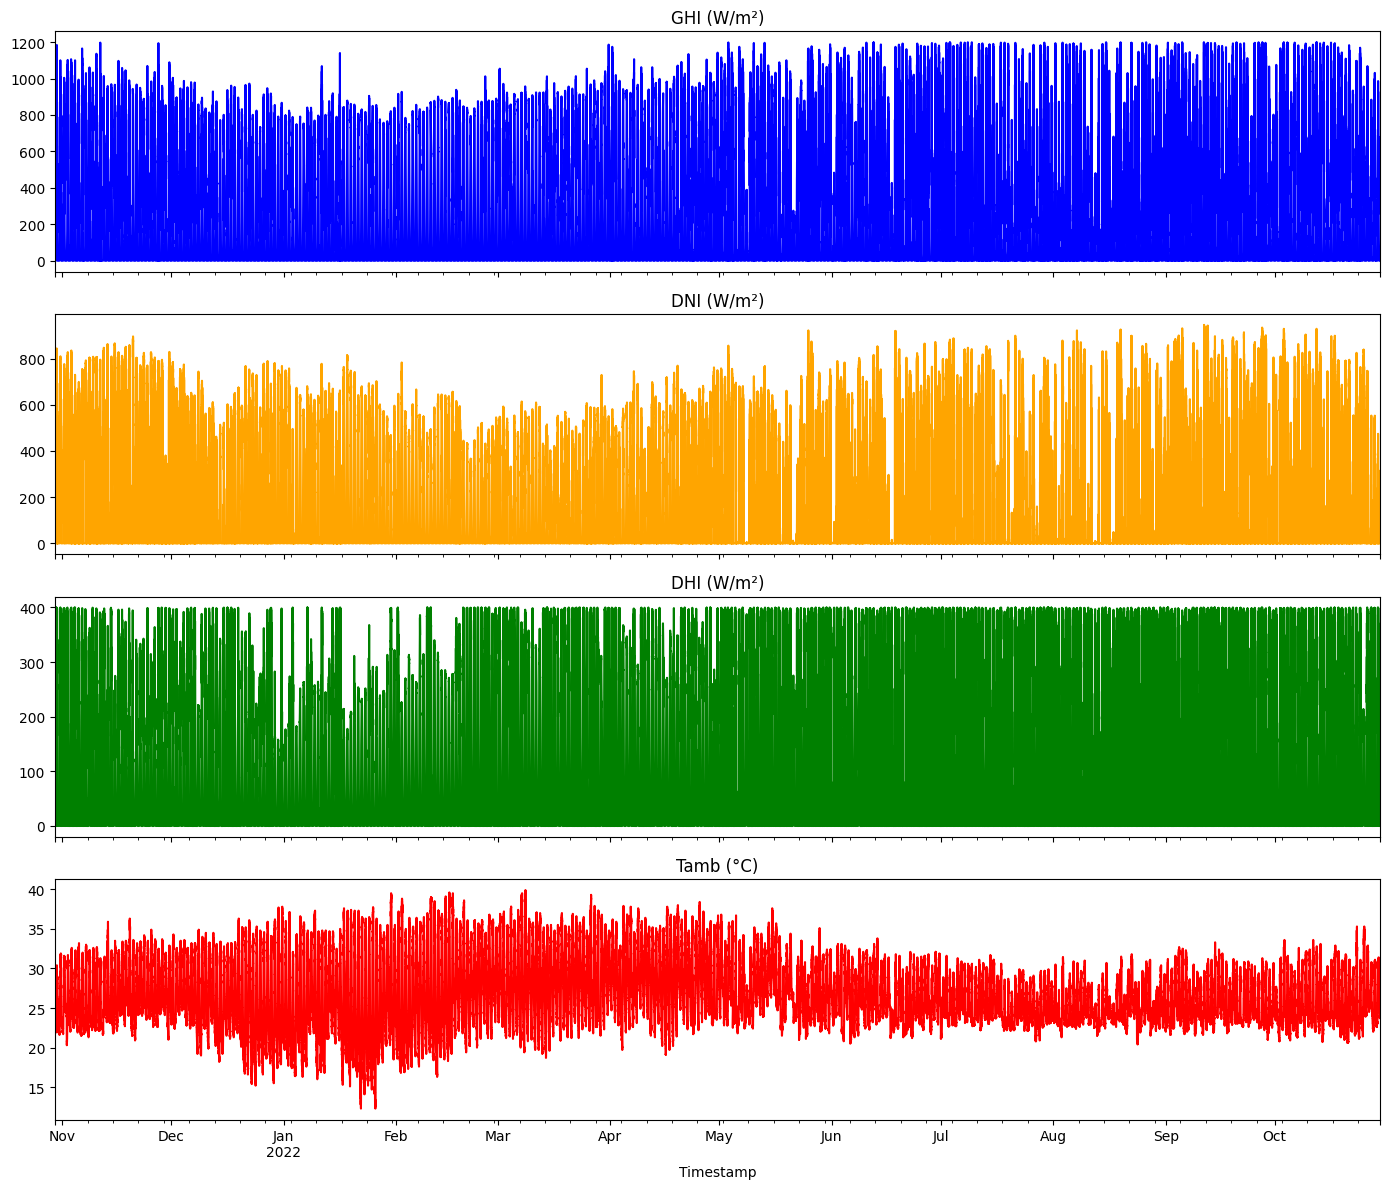

In [31]:
# Convert Timestamp to datetime and set as index

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# Plot GHI, DNI, DHI, Tamb in subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# Solar Irradiance
df['GHI'].plot(ax=axes[0], color='blue', title='GHI (W/m²)')
df['DNI'].plot(ax=axes[1], color='orange', title='DNI (W/m²)')
df['DHI'].plot(ax=axes[2], color='green', title='DHI (W/m²)')

# Ambient Temperature
df['Tamb'].plot(ax=axes[3], color='red', title='Tamb (°C)')

plt.tight_layout()
plt.show()

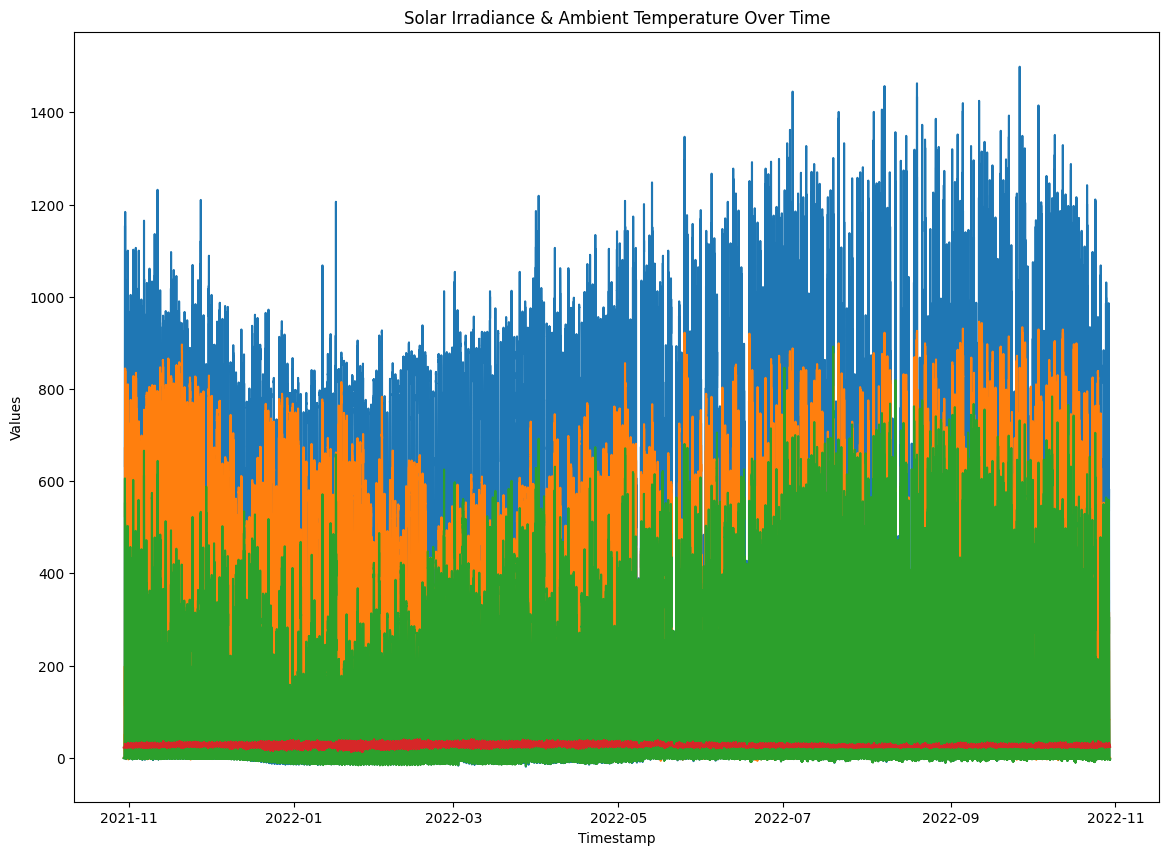

In [32]:
df = pd.read_csv('..\\data\\sierraleone-bumbuna.csv', parse_dates=['Timestamp'])  # add parse_dates parameter
# Convert 'Timestamp' to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Optionally set as index for easier plotting
df.set_index('Timestamp', inplace=True)

plt.figure(figsize=(14, 10))

# Plot each variable
plt.plot(df.index, df['GHI'], label='GHI')
plt.plot(df.index, df['DNI'], label='DNI')
plt.plot(df.index, df['DHI'], label='DHI')
plt.plot(df.index, df['Tamb'], label='Tamb')

plt.xlabel('Timestamp')
plt.ylabel('Values')
plt.title('Solar Irradiance & Ambient Temperature Over Time')
#plt.legend()
plt.show()

C:\Users\mulatyazew.CBE\AppData\Local\Temp\ipykernel_14668\3478173750.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = df.resample('M').mean()


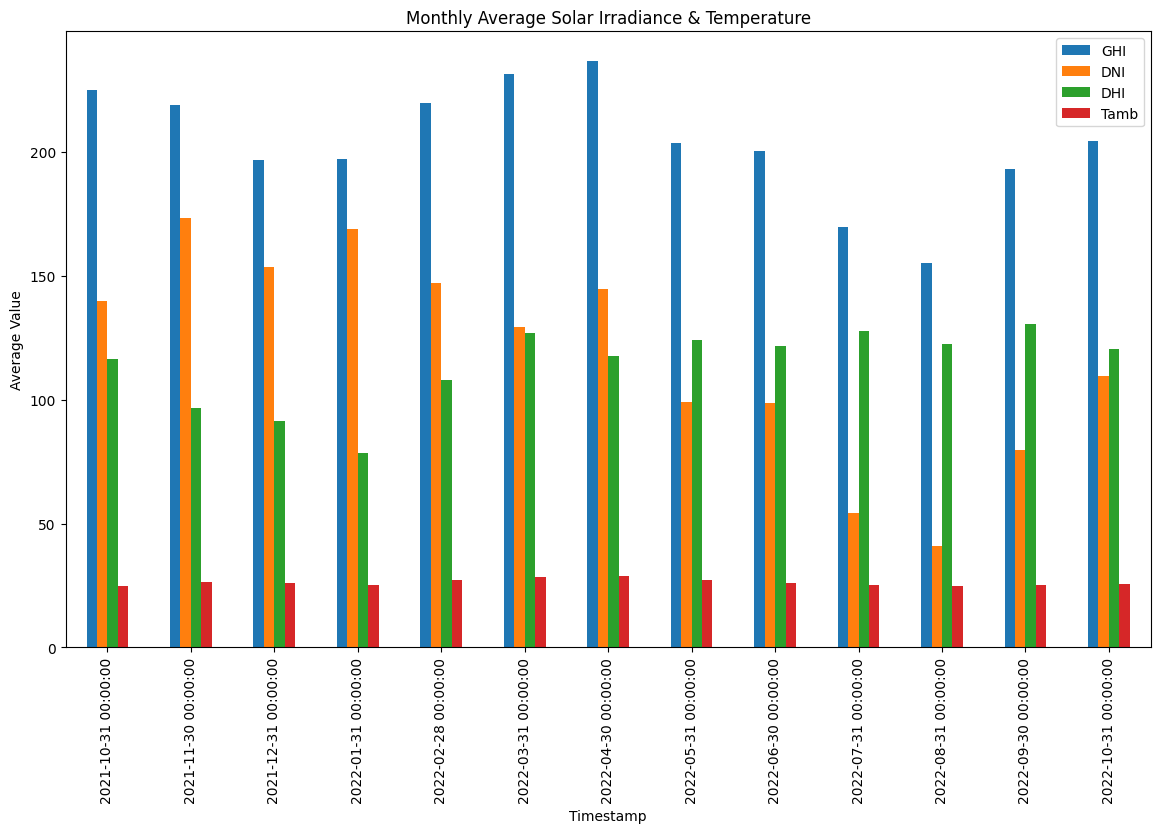

In [33]:
# Monthly average values
monthly_avg = df.resample('M').mean()

monthly_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(kind='bar', figsize=(14, 8))
plt.title('Monthly Average Solar Irradiance & Temperature')
plt.ylabel('Average Value')
plt.show()


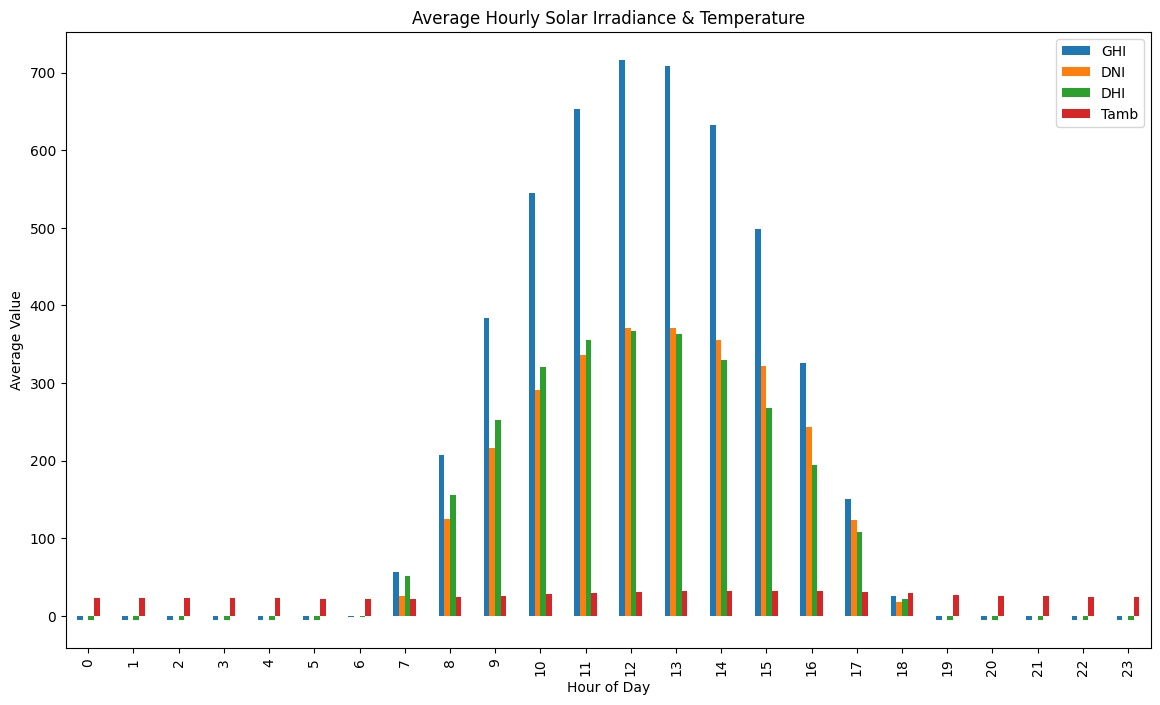

In [34]:
# Hourly average (aggregated across all days)
hourly_avg = df.groupby(df.index.hour).mean()

hourly_avg[['GHI', 'DNI', 'DHI', 'Tamb']].plot(kind='bar', figsize=(14, 8))
plt.title('Average Hourly Solar Irradiance & Temperature')
plt.xlabel('Hour of Day')
plt.ylabel('Average Value')
plt.show()

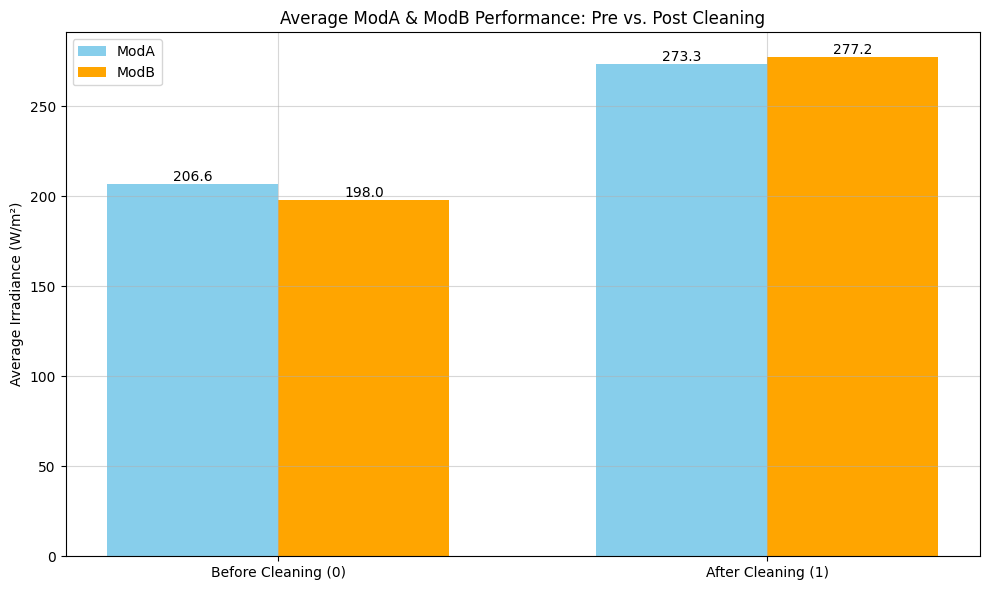

Total cleaning done:
 GHI              145072.6
DNI               68654.9
DHI              104682.3
ModA             138841.1
ModB             140833.4
Tamb              12564.3
RH                43878.1
WS                  317.8
WSgust              553.8
WSstdev             153.2
WD                51694.2
WDstdev            2841.1
BP               508554.0
Cleaning            508.0
Precipitation         0.3
TModA             16628.8
TModB             17010.5
Comments              0.0
dtype: float64


In [35]:

# 1. Group by Cleaning flag and calculate means
cleaning_groups = df.groupby('Cleaning')[['ModA', 'ModB']].mean()

# 2. Plot the results
plt.figure(figsize=(10, 6))

# Bar positions
x = [0, 1]  # 0=Before cleaning (0), 1=After cleaning (1)
width = 0.35

# Plot ModA and ModB bars side by side
bars_moda = plt.bar([pos - width/2 for pos in x], 
                   cleaning_groups['ModA'], 
                   width, label='ModA', color='skyblue')
bars_modb = plt.bar([pos + width/2 for pos in x], 
                   cleaning_groups['ModB'], 
                   width, label='ModB', color='orange')

# Customize plot
plt.xticks(x, ['Before Cleaning (0)', 'After Cleaning (1)'])
plt.ylabel('Average Irradiance (W/m²)')
plt.title('Average ModA & ModB Performance: Pre vs. Post Cleaning')
plt.legend()

# Add value labels on top of bars
for bars in [bars_moda, bars_modb]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom')

plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.show()
# 3. Calculate total cleaning done
cleaning = df[df['Cleaning'] == 1].sum()
print(f"Total cleaning done:\n {cleaning}")

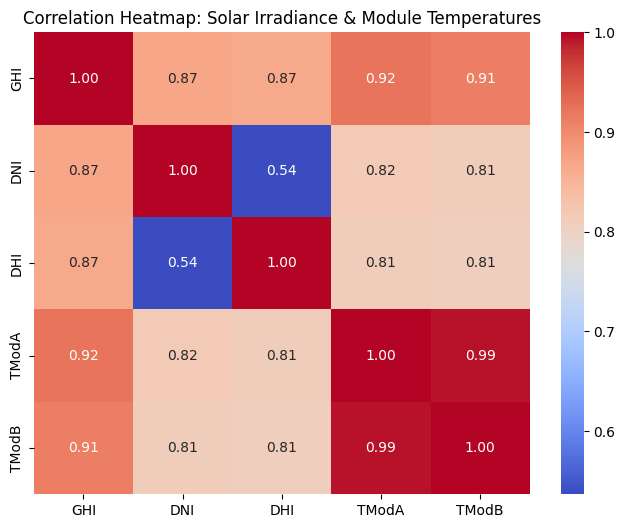

In [36]:
# Select columns of interest
corr_columns = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df[corr_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: Solar Irradiance & Module Temperatures')
plt.show()

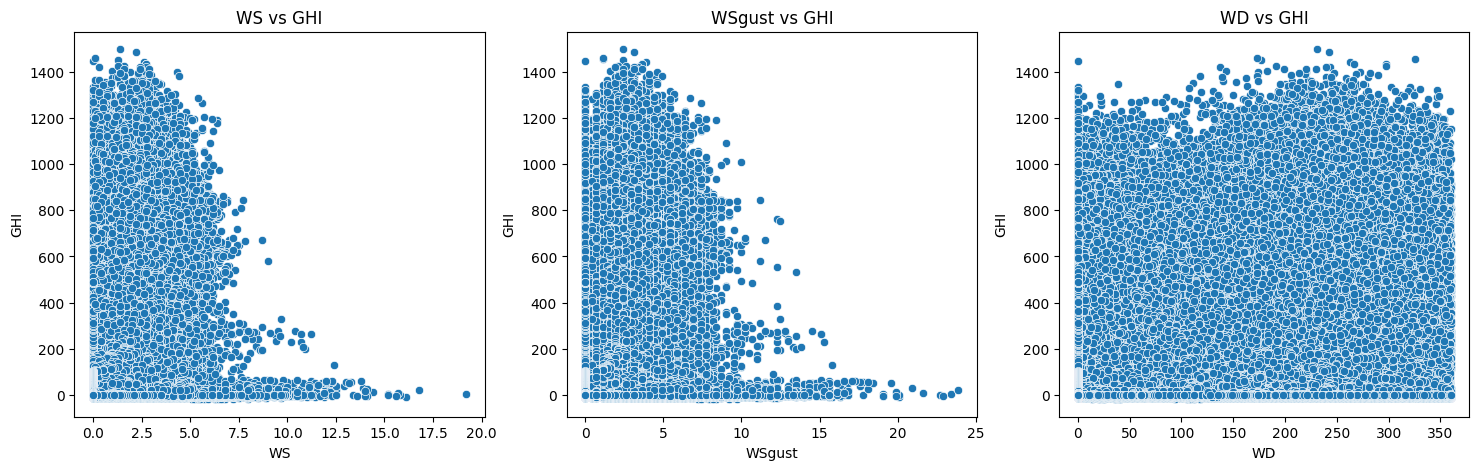

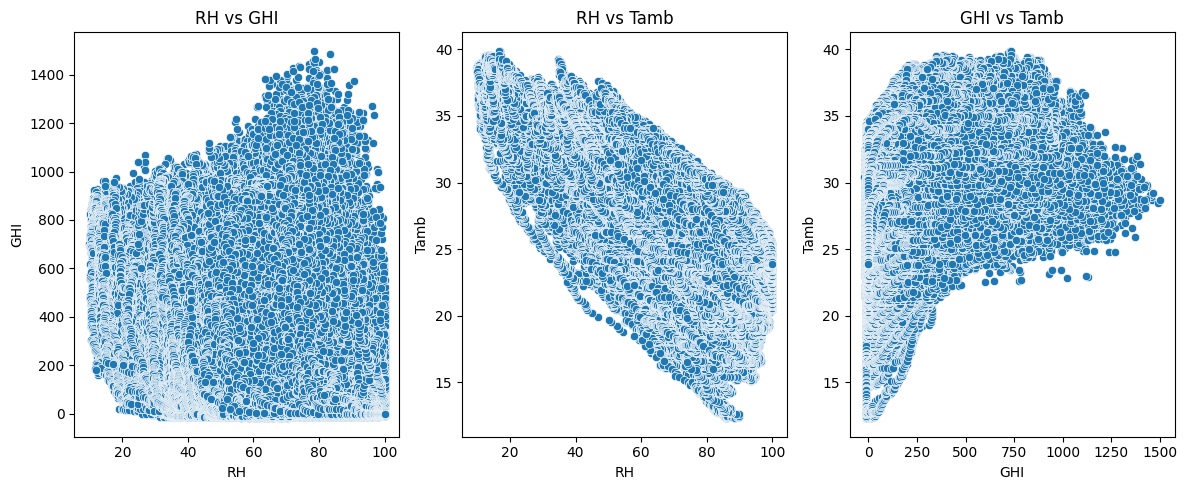

<Figure size 640x480 with 0 Axes>

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(data=df, x='WS', y='GHI', ax=axs[0])
axs[0].set_title('WS vs GHI')

sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axs[1])
axs[1].set_title('WSgust vs GHI')

sns.scatterplot(data=df, x='WD', y='GHI', ax=axs[2])
axs[2].set_title('WD vs GHI')


fig, axs = plt.subplots(1, 3, figsize=(12, 5))
sns.scatterplot(data=df, x='RH', y='GHI', ax=axs[0])
axs[0].set_title('RH vs GHI')

sns.scatterplot(data=df, x='RH', y='Tamb', ax=axs[1])
axs[1].set_title('RH vs Tamb')

sns.scatterplot(data=df, x='GHI', y='Tamb', ax=axs[2])
axs[2].set_title('GHI vs Tamb')


plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()


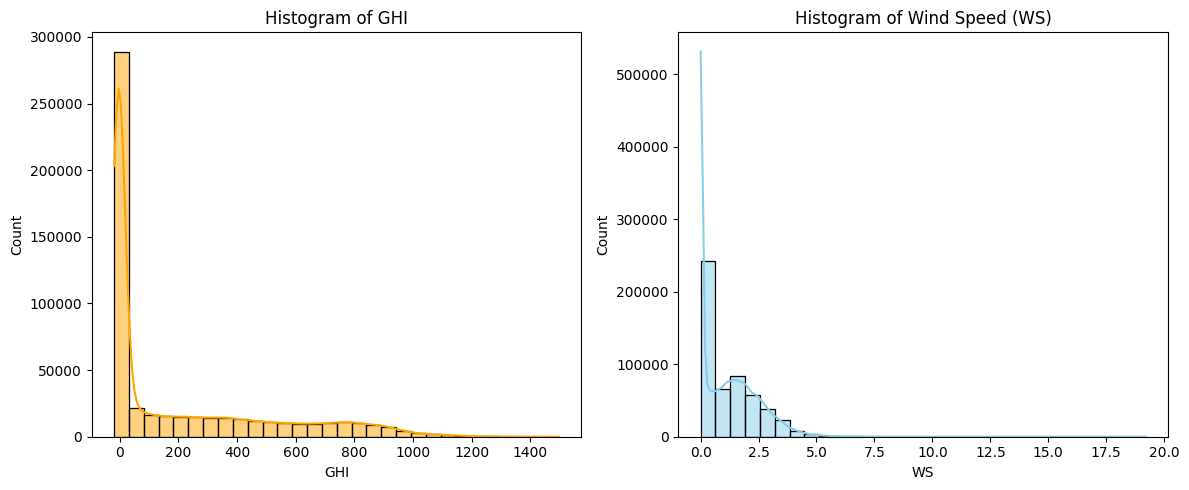

In [38]:
# Drop NaNs if needed
df_hist = df[['GHI', 'WS']].dropna()

# Histogram for GHI
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_hist['GHI'], bins=30, kde=True, color='orange')
plt.title("Histogram of GHI")

# Histogram for WS
plt.subplot(1, 2, 2)
sns.histplot(df_hist['WS'], bins=30, kde=True, color='skyblue')
plt.title("Histogram of Wind Speed (WS)")

plt.tight_layout()
plt.show()

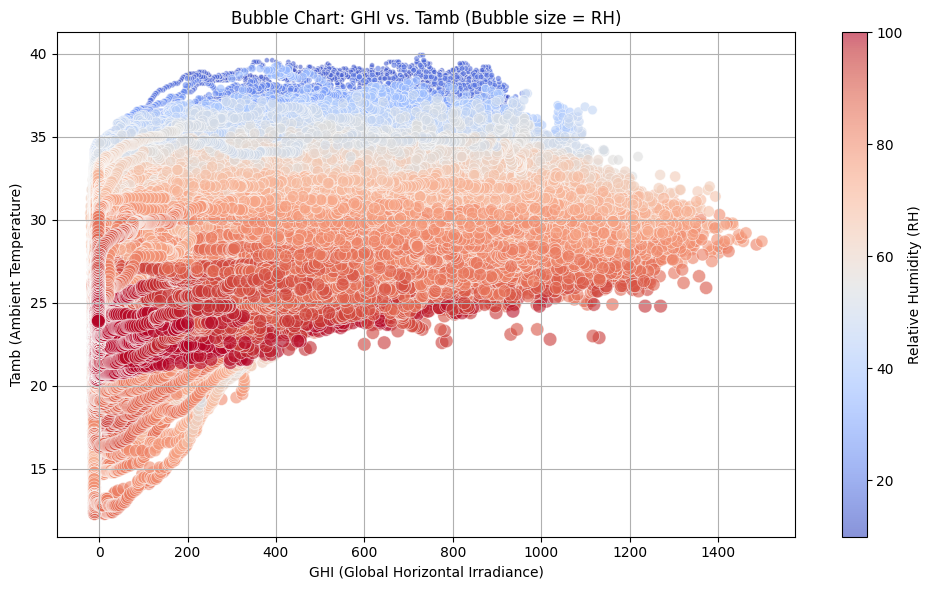

In [39]:
# Drop rows with missing values in relevant columns
df_bubble = df[['GHI', 'Tamb', 'RH']].dropna()

# Create the bubble chart
plt.figure(figsize=(10, 6))
plt.scatter(
    df_bubble['GHI'], 
    df_bubble['Tamb'], 
    s=df_bubble['RH'],        # Bubble size = Relative Humidity
    c=df_bubble['RH'],        # Color (optional, also RH here)
    cmap='coolwarm', 
    alpha=0.6, 
    edgecolors='w', 
    linewidth=0.5
)

plt.title('Bubble Chart: GHI vs. Tamb (Bubble size = RH)')
plt.xlabel('GHI (Global Horizontal Irradiance)')
plt.ylabel('Tamb (Ambient Temperature)')
plt.colorbar(label='Relative Humidity (RH)')
plt.grid(True)
plt.tight_layout()
plt.show()
